# Workflow

In [1]:
import os
from joblib import dump
from pathlib import Path

import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import numpy as np

import time
from scipy.stats import loguniform, randint
from yellowbrick.model_selection import RFECV
from scipy.stats import loguniform, randint
from sklearn.model_selection import RandomizedSearchCV
import warnings

In [2]:
# import cuml
# from cuml.linear_model import LogisticRegression as cuLogisticRegression
# from sklearn.model_selection import RandomizedSearchCV
# import cudf
start_time = time.time()

In [3]:
# Set up directory
os.chdir("/home/siti/Downloads/New Modelling")

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('AE_Synthetic_Data_Final_V02.csv')

In [4]:
print(df["LOS_Category"].value_counts())

Short stay    11942983
Long stay       779233
Name: LOS_Category, dtype: int64


In [5]:
results_folder = Path("LogisticRegression_folder/SMOTETOMEK/Model 1")
results_folder.mkdir(parents=True, exist_ok=True) 

In [6]:
# Convert object types to category
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [7]:
# Create a copy of df for modelling
data = df.copy()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12722216 entries, 0 to 12722215
Data columns (total 13 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   IMD_Category           category
 1   Age_Band               category
 2   Sex                    category
 3   AE_Arrive_HourOfDay    category
 4   AE_Time_Mins           int64   
 5   AE_HRG                 category
 6   AE_Num_Diagnoses       int64   
 7   AE_Num_Investigations  int64   
 8   AE_Num_Treatments      int64   
 9   AE_Arrival_Mode        category
 10  ICD10_Chapter_Code     category
 11  TFC                    category
 12  LOS_Category           category
dtypes: category(9), int64(4)
memory usage: 497.4 MB


In [8]:
# Define the features and target
feature_cols = data.columns[data.columns != 'LOS_Category']
X = data[feature_cols]
y = data['LOS_Category']


# Step 1: Map the Outcome Variable

In [9]:
y = y.map({'Short stay': 1, 'Long stay': 0})

In [10]:
print(y.value_counts())

1    11942983
0      779233
Name: LOS_Category, dtype: int64


# Step 2: Split Data

In [11]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y) 
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

**Overall Proportions:**

- **Test set**: 15% of the original dataset
- **Validation set**: 0.1765 * 0.85 = 0.15 or 15% of the original dataset
- **Training set**: 1−0.15−0.15 = 0.7 or 70% of the original dataset

So, by using this two-step splitting, we've achieved a 70-15-15 split for the training, validation, and test datasets, respectively.

# Step 3: One-Hot Encoding 

In [12]:
# Your nominal columns
nominal_columns = ['Sex', 'AE_Arrival_Mode', 'ICD10_Chapter_Code', 'TFC']

# One-hot encoding
X_train = pd.get_dummies(X_train, columns=nominal_columns, drop_first=True)
X_val = pd.get_dummies(X_val, columns=nominal_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=nominal_columns, drop_first=True)

# Get all columns in X_train after one-hot encoding
all_columns = X_train.columns

# Ensure X_val has the same columns as X_train
for col in all_columns:
    if col not in X_val.columns:
        X_val[col] = 0

# Ensure X_test has the same columns as X_train
for col in all_columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Reorder columns in X_val and X_test to match X_train's order
X_val = X_val[all_columns]
X_test = X_test[all_columns]


# Step 4: Ordinal Encoding

In [13]:
orders = {
    'IMD_Category': ['Most deprived 20%', '20% - 40%', '40 - 60%', '60% - 80%', 'Least deprived 20%'],
    'Age_Band': ['01-17', '18-24', '25-44', '45-64', '65-84', '85+'],
    'AE_Arrive_HourOfDay': ['01-04','05-08','09-12','13-16','17-20','21-24'],
    'AE_HRG': ['Nothing', 'Low', 'Medium', 'High']
}

# Loop through each column and its respective order to encode
for col, order in orders.items():
    ordinal_encoder = OrdinalEncoder(categories=[order])
    X_train[col] = ordinal_encoder.fit_transform(X_train[[col]])
    X_val[col] = ordinal_encoder.transform(X_val[[col]])
    X_test[col] = ordinal_encoder.transform(X_test[[col]])

# Step 5: Oversampling with SMOTE

In [14]:
# Load the oversampled data from the CSV file
df_loaded = pd.read_csv('model1_smotetomek_oversampled_data.csv')

# Separate the features and target variable
X_train_resampled = df_loaded.drop('LOS_Category', axis=1)
y_train_resampled = df_loaded['LOS_Category']

In [15]:
proportions = y_train_resampled.value_counts(normalize=True)
print(proportions)

counts = y_train_resampled.value_counts(normalize=False)
print(counts)

1    0.5
0    0.5
Name: LOS_Category, dtype: float64
1    8358604
0    8358604
Name: LOS_Category, dtype: int64


In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

# Use only 10% of the data for hyperparameter tuning using stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, subset_index in sss.split(X_train_resampled, y_train_resampled):
    X_train_subset = X_train_resampled.iloc[subset_index]
    y_train_subset = y_train_resampled.iloc[subset_index]
    
# Standardize the subset
scaler = StandardScaler()
X_train_subset_scaled = scaler.fit_transform(X_train_subset)

In [17]:
counts = y_train_subset.value_counts(normalize=False)
print(counts)

0    835861
1    835860
Name: LOS_Category, dtype: int64


# Step 6: Standardize Dataset

In [18]:
# Scale the rest of the data using the subset's statistics
X_train_scaled = scaler.transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 7: RFECV

Perform RFECV on the training set (not including the validation set).

In [19]:
from yellowbrick.model_selection import RFECV

RFECV took 2087.78 seconds.


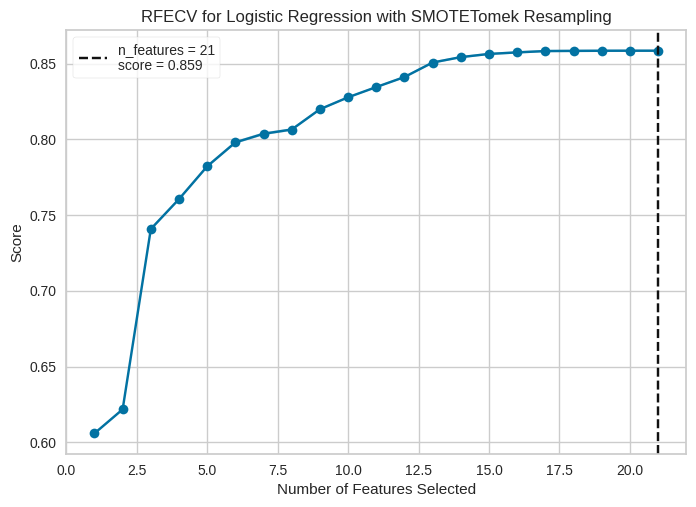

In [20]:
# Record the start time
start_time = time.time()


# Initialize the Logistic Regression estimator
estimator = LogisticRegression(max_iter=5000, random_state=42)

plt_title = "RFECV for Logistic Regression with SMOTETomek Resampling"

# Use RFECV from Yellowbrick with the settings
visualizer = RFECV(estimator, step=1, cv=5, title=plt_title, n_jobs = 7, scoring='roc_auc')

# Assuming X_train_subset_scaled has been pre-scaled. If not, scale it first.
visualizer.fit(X_train_subset_scaled, y_train_subset)

# Show the visualizer
visualizer.show(outpath= results_folder / "RFECV.png")

# Record the end time
end_time = time.time()

# Calculate and print the duration
duration = end_time - start_time
print(f"RFECV took {duration:.2f} seconds.")

In [21]:
# Print the features selected by RFECV
feature_names = X_train.columns

# Map the selected features to the original column names
selected_features = [feature for mask, feature in zip(visualizer.support_, feature_names) if mask]

print("Selected Features:", selected_features)

Selected Features: ['IMD_Category', 'Age_Band', 'AE_Arrive_HourOfDay', 'AE_Time_Mins', 'AE_HRG', 'AE_Num_Diagnoses', 'AE_Num_Investigations', 'AE_Num_Treatments', 'Sex_Male', 'AE_Arrival_Mode_Not known', 'AE_Arrival_Mode_Other', 'ICD10_Chapter_Code_Other', 'ICD10_Chapter_Code_X', 'ICD10_Chapter_Code_XI', 'ICD10_Chapter_Code_XIV', 'ICD10_Chapter_Code_XIX', 'ICD10_Chapter_Code_XVIII', 'TFC_180', 'TFC_300', 'TFC_420', 'TFC_OTHER']


# Step 8: Hyperparameter Tuning with Randomized Search CV

After feature selection, use RandomizedSearchCV for hyperparameter tuning on the training set. The cross-validation within RandomizedSearchCV uses multiple train-validation splits of the training data.

Use only 10% percent of the training set to perform hyperparameter tuning due to insuffient CPU and GPU resources. The training set is very high after oversampling.

In [22]:

selected_feature_indices = [X_train.columns.get_loc(feature) for feature in selected_features]
X_train_selected_scaled = X_train_scaled[:, selected_feature_indices]

# Filter X_train_subset_scaled with the best features
X_train_selected_subset_scaled = X_train_subset_scaled[:, selected_feature_indices]

In [ ]:
# Initialize the Logistic Regression estimator
estimator = LogisticRegression(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'C': loguniform(1e-1, 1e1), # narrowed down the range; before (from 1e-3 to 1e2)
    'penalty': ['l2'],
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs','sag'],
    'max_iter': randint(500, 10000) # increased max iterations from 5000 to 10000
}

# Record the start time
start_time = time.time()

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator, param_distributions=param_dist, 
                                   scoring = 'roc_auc', error_score='raise',
                                   n_iter=50, cv=5, verbose=1, n_jobs=7, random_state=42)

random_search.fit(X_train_selected_subset_scaled, y_train_subset)

# Save the cv_results_ to a DataFrame and then to a CSV file
cv_results_df = pd.DataFrame(random_search.cv_results_)
cv_results_df.to_csv(results_folder / 'cv_results.csv', index=False)

# Print results
print("Best parameters for LR:", random_search.best_params_)
print("Best ROC-AUC score LR:", random_search.best_score_)


# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Hyperparameter tuning for LR took {duration:.2f} seconds.")

# Save the model
dump(random_search, results_folder / 'random_search_model.joblib')

# Step 9: Train the whole dataset with best hyperparameters


In [24]:
# Extracting selected features for validation, and test sets:

X_val_selected_scaled = X_val_scaled[:, selected_feature_indices]
X_test_selected_scaled = X_test_scaled[:, selected_feature_indices]

In [25]:

# Define the best hyperparameters
best_params = random_search.best_params_

# Record the start time
start_time = time.time()

# Train a DT model using the best hyperparameters on the training set
best_model = LogisticRegression(**best_params)
best_model.fit(X_train_selected_scaled, y_train_resampled)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Training for LR took {duration:.2f} seconds.")


Training for LR took 21.34 seconds.


# Step 10: Predict and Evaluate on Validation Set

In [26]:
y_val_pred = best_model.predict(X_val_selected_scaled)
y_val_prob = best_model.predict_proba(X_val_selected_scaled)[:, 1]

# Evaluate the performance on the validation set using multiple metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_prob)  # Note: roc_auc_score uses probability estimates
val_f1 = f1_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

# Print the metrics
print("Validation Metrics:")
print("Accuracy:", val_accuracy)
print("ROC-AUC:", val_roc_auc)
print("F1 Score:", val_f1)
print("Precision:", val_precision)
print("Recall:", val_recall)


Validation Metrics:
Accuracy: 0.740856762184391
ROC-AUC: 0.7293480164510668
F1 Score: 0.8452921474693815
Precision: 0.9615024723607221
Recall: 0.7541438607124779


# Step 11: Final Model Training and Test Evaluation

Finally, we train on the combined train+validation data and test on the test set.

In [27]:
import numpy as np

# Combine the training and validation sets
X_combined = np.concatenate([X_train_selected_scaled, X_val_selected_scaled], axis=0)
y_combined = np.concatenate([y_train_resampled, y_val], axis=0)

# Record the start time
start_time = time.time()

# Train the final model on the combined set
final_model = LogisticRegression(**best_params)
final_model.fit(X_combined, y_combined)

# Record the end time
end_time = time.time()
duration = end_time - start_time

print(f"Training LR took {duration:.2f} seconds.")

Training LR took 25.40 seconds.


In [44]:
dump(final_model, results_folder / 'final_model_LR.joblib')

['LogisticRegression_folder/SMOTETOMEK/Model 1/final_model_LR.joblib']

# Step 12: Predict on test set

In [28]:
# Predict on the test set
y_test_pred = final_model.predict(X_test_selected_scaled)
y_test_prob = final_model.predict_proba(X_test_selected_scaled)[:, 1]  # Probabilities for the positive class

# Evaluate the performance on the test set using multiple metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print the metrics
print("Test Metrics:")
print("Accuracy:", test_accuracy)
print("ROC-AUC:", test_roc_auc)
print("F1 Score:", test_f1)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("Confusion Matrix:")
print(test_conf_matrix)

Test Metrics:
Accuracy: 0.7700474707506499
ROC-AUC: 0.7307648847862338
F1 Score: 0.8656448359604723
Precision: 0.9586042329506156
Recall: 0.7891208675886768
Confusion Matrix:
[[  55838   61047]
 [ 377779 1413669]]


# Step 13: Save the metrics

In [29]:
# Save all metrics in a csv file

metrics = {
    "ROC-AUC Test": test_roc_auc ,
    "Accuracy": test_accuracy,
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Confusion Matrix": test_conf_matrix
}

# Convert the metrics to a DataFrame
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])

# Save to CSV
output_path = results_folder / "Model1_Performance_metrics.csv"
metrics_df.to_csv(output_path, index=False)

print(f"Metrics saved to: {output_path}")

Metrics saved to: LogisticRegression_folder/SMOTETOMEK/Model 1/Model1_Performance_metrics.csv


# ROC-AUC Curve

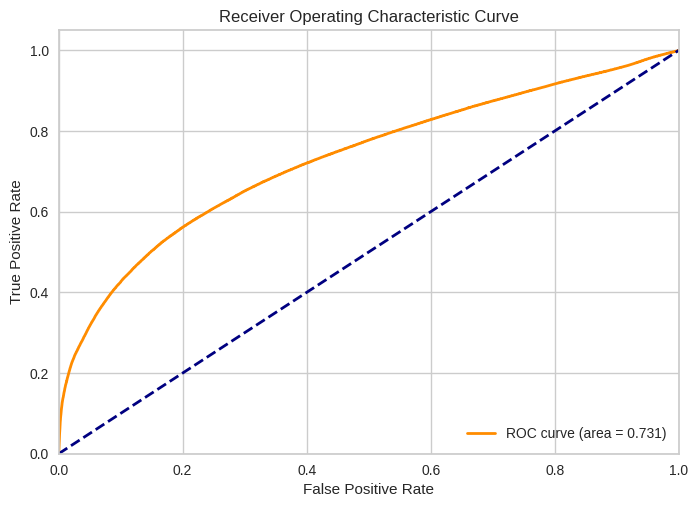

In [30]:


# y_test_prob contains the predicted probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.savefig(results_folder / "roc_auc.png", dpi=300)
plt.show()


# Precision-Recall Curve

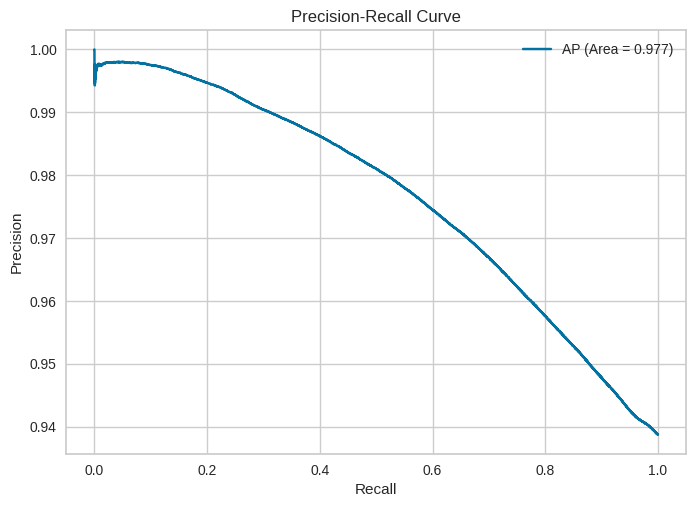

In [31]:
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
average_precision = average_precision_score(y_test, y_test_prob)

plt.figure()
plt.plot(recall, precision, label='AP (Area = %0.3f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.savefig(results_folder / "precision_recall.png", dpi=300)
plt.show()

# Calculate Error

In [32]:
# Predict on training set
y_combined_pred = final_model.predict(X_combined)
combined_accuracy = accuracy_score(y_combined, y_combined_pred)
combined_error = 1 - combined_accuracy

# Predict on validation set
y_val_pred = final_model.predict(X_val_selected_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_error = 1 - val_accuracy

# Predict on test set
y_test_pred = final_model.predict(X_test_selected_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy

print(f"Combined Error: {combined_error:.3f}")
print(f"Validation Error: {val_error:.3f}")
print(f"Test Error: {test_error:.3f}")

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Combined Error', 'Validation Error', 'Test Error'],
    'Value': [combined_error, val_error, test_error]
})

# Save the DataFrame to a CSV file
metrics_df.to_csv(results_folder / 'Model_Metrics.csv', index=False)

Combined Error: 0.231
Validation Error: 0.230
Test Error: 0.230


# Feature Importance

For a logistic regression model, the coefficients represent the log-odds for the response variable. You can retrieve the coefficients directly from the trained model.

In [33]:
coefficients = final_model.coef_[0]


## Calculate Odds Ratios
The odds ratio for a feature represents how the odds of the positive class change with a one-unit increase in that feature while holding other features constant.

In [34]:
odds_ratios = np.exp(coefficients)

## Rank Features Base don Importance

Rank the features based on the magnitude of their coefficients. The magnitude indicates the importance of the feature, regardless of its direction (positive or negative effect).

In [35]:
# Match Feature Importance to Feature Names:
feature_names = [X_train.columns[i] for i in selected_feature_indices]

sorted_indices = np.argsort(np.abs(coefficients))[::-1]

ranked_features = [feature_names[i] for i in sorted_indices]
ranked_coefficients = [coefficients[i] for i in sorted_indices]
ranked_odds_ratios = [odds_ratios[i] for i in sorted_indices]


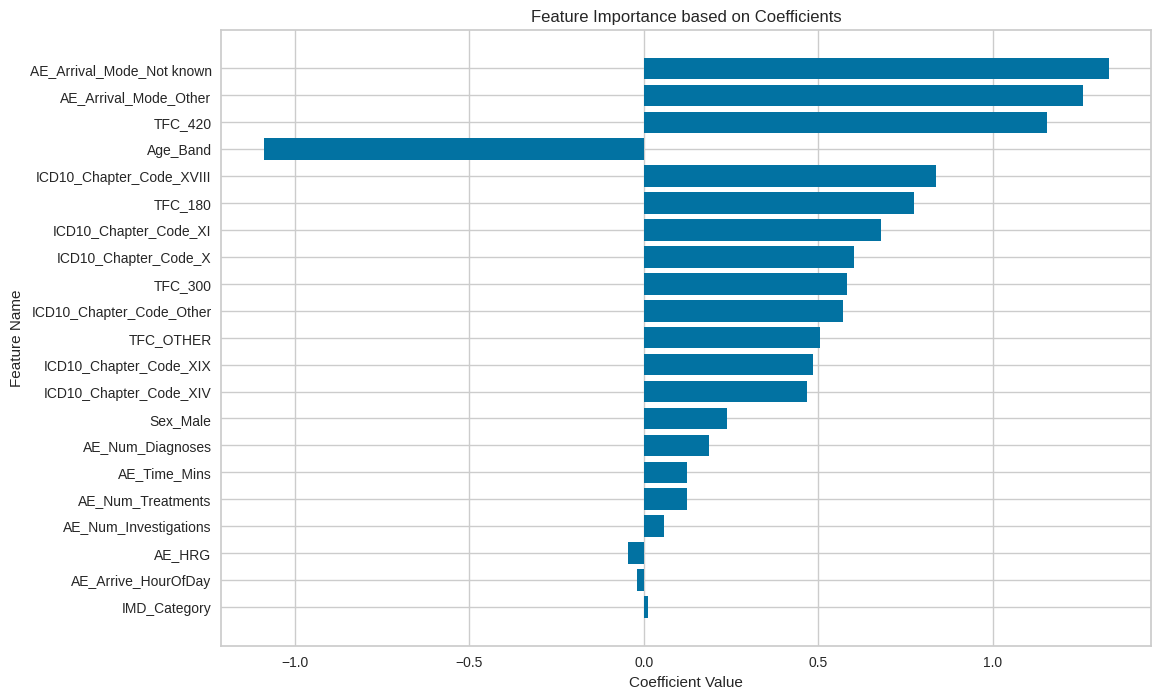

In [36]:
# Visualisation

plt.figure(figsize=(12,8))
plt.barh(ranked_features, ranked_coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance based on Coefficients')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.savefig(results_folder / "Feature_Importance_coeff.png", dpi=300)
plt.show()



A positive coefficient suggests that as the feature value increases, the log-odds of the response variable being 1 also increase, making the response more likely to be 1. Conversely, a negative coefficient suggests the opposite.

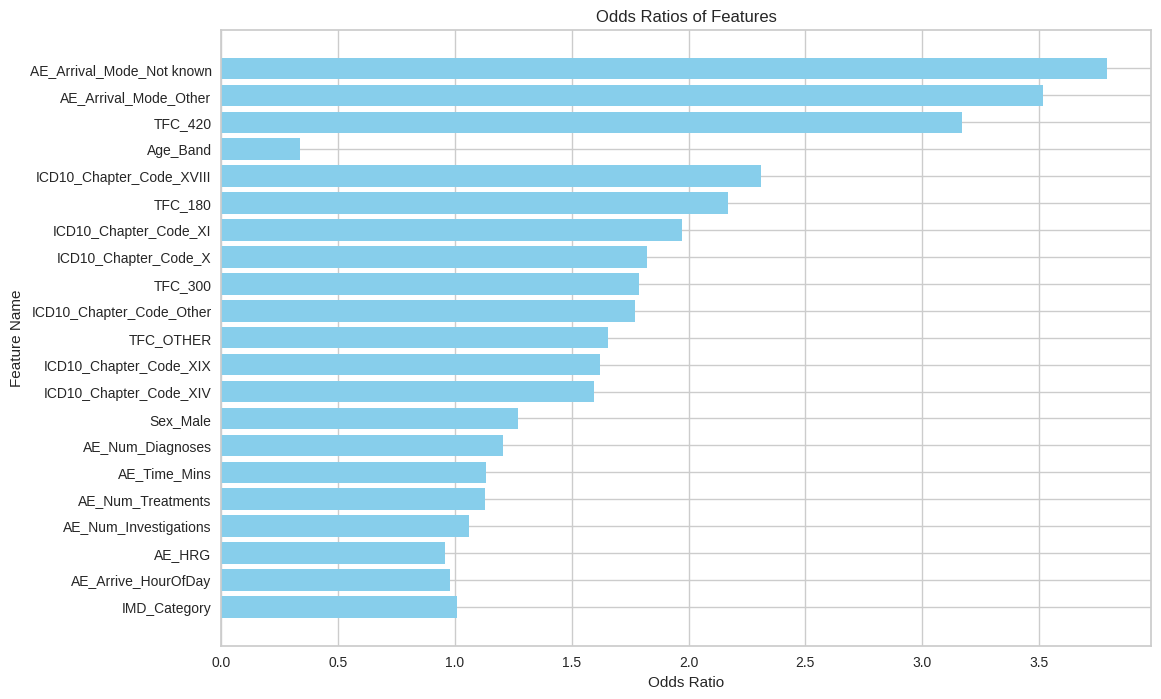

In [37]:
plt.figure(figsize=(12,8))
plt.barh(ranked_features, ranked_odds_ratios, color='skyblue')
plt.xlabel('Odds Ratio')
plt.ylabel('Feature Name')
plt.title('Odds Ratios of Features')
plt.gca().invert_yaxis()
plt.savefig(results_folder / "Feature_Importance_odds.png", dpi=300)
plt.show()


In [38]:
# Create a DataFrame
df = pd.DataFrame({
    'Feature': ranked_features,
    'Coefficient': ranked_coefficients,
    'Odds Ratio': ranked_odds_ratios
})

# Save DataFrame to CSV file
df.to_csv(results_folder / 'logistic_regression_coefficients.csv', index=False)

# Significance of Features to Outcome Variable

In [39]:
X_train_selected_scaled_df = pd.DataFrame(X_train_selected_scaled, columns=selected_features)
X_val_selected_scaled_df = pd.DataFrame(X_val_selected_scaled, columns=selected_features)

# Combine the training and validation sets
X_combined = pd.concat([X_train_selected_scaled_df, X_val_selected_scaled_df])

In [40]:
X_with_intercept = sm.add_constant(X_combined)
model = sm.Logit(y_combined, X_with_intercept).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.465262
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:             18625859
Model:                          Logit   Df Residuals:                 18625837
Method:                           MLE   Df Model:                           21
Date:                Sun, 10 Sep 2023   Pseudo R-squ.:                  0.3248
Time:                        14:54:09   Log-Likelihood:            -8.6659e+06
converged:                       True   LL-Null:                   -1.2835e+07
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.3983      0.001    473.613      0.000       0.

In [41]:
# Save the summary as a dataframe
# Get the summary as a DataFrame
summary_df = model.summary2().tables[1]

# Save the DataFrame to a CSV file
summary_df.to_csv(results_folder / 'Model1_summary.csv')